# Proyecto de Inteligencia Artificial - FaMAF - UNC - Argentina

Integrantes:

Ramos, Pablo Nicolas

# Objetivo General

Implementar métodos inteligentes en la tarea de clasificación características de la cobertura terrestre en entornos salares.

# Alcance

Este trabajo se centra en la aplicación de métodos inteligentes para la clasificación de cobertura terrestre en ambientes salares, utilizando imágenes satelitales multiespectrales (Sentinel-2). Se utilizan muestras representativas generadas a partir de polígonos etiquetados automáticamente, con el objetivo de generar mapas temáticos que identifiquen clases como “salina”, “agua/humedad”, “vegetación” y “suelo desnudo”. El enfoque permite explorar patrones espectrales y establecer una línea base para el monitoreo de cambios en estos ecosistemas.

# Se usaron imágenes Sentinel L2C

Para observar las imágenes y archivos necesarios para ejecutar el notebook, descargar los archivos del siguiente enlace:

https://drive.google.com/drive/folders/18pogMHfKS9t0q1LtTIu3Pcs-yibxFcgF?usp=sharing

In [1]:
from rasterio.features import shapes
from shapely.geometry import shape
from sklearn.cluster import KMeans
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.plot import reshape_as_image, reshape_as_raster
from shapely.geometry import mapping
from sklearn.ensemble import RandomForestClassifier
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from rasterio.warp import reproject, Resampling
from rasterio.transform import array_bounds
from sklearn.preprocessing import StandardScaler
from skimage.morphology import binary_dilation, square

import time
import os
import json
import rasterio
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import joblib
import seaborn as sns

In [2]:
ruta_imagenes = os.path.join(os.getcwd(), "imagenes")
bandas_dir = os.path.join(ruta_imagenes, "bandas")

# Lista de bandas disponibles 
bandas_disponibles = [ 
    "B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12" 
]

def nombre_archivo(banda): 
    return f"2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_{banda}_(Raw).tiff"

banda_ref = "B02" # 10m resolución 
ref_path = os.path.join(bandas_dir, nombre_archivo(banda_ref)) 
if not os.path.exists(ref_path): 
    raise FileNotFoundError(f"No encuentro la banda de referencia: {ref_path}")

with rasterio.open(ref_path) as ref: 
    ref_transform = ref.transform 
    ref_crs = ref.crs 
    ref_height = ref.height 
    ref_width = ref.width 
    ref_shape = (ref_height, ref_width) 
    ref_profile = ref.profile

def read_resample_to_ref(src_path, resampling=Resampling.bilinear):
    
    if not os.path.exists(src_path): 
        
        return None 
        
    with rasterio.open(src_path) as src: # destino float32 y con NaN como nodata para poder usar np.nan_to_num luego 
        
        dst = np.empty(ref_shape, dtype=np.float32) 
        
        reproject( 
            source=rasterio.band(src, 1), 
            destination=dst, 
            src_transform=src.transform, 
            src_crs=src.crs, 
            dst_transform=ref_transform, 
            dst_crs=ref_crs, 
            dst_nodata=np.nan, 
            resampling=resampling
        ) 
        return dst

imagenes = []
bandas_cargadas = []
for b in bandas_disponibles: 
    path = os.path.join(bandas_dir, nombre_archivo(b)) # Para todas las bandas ópticas usamos bilinear. (Para SCL sería nearest.) 
    img = read_resample_to_ref(path, resampling=Resampling.bilinear) 
    if img is not None: 
        imagenes.append(img) 
        bandas_cargadas.append(b) 
    else: 
        print(f"[Aviso] No se encontró la banda: {path}")
        
if not imagenes: 
    raise RuntimeError("No se pudieron cargar/re-muestrear bandas.")


# Stack de bandas y aplanamiento 
stack = np.stack(imagenes, axis=-1) # (H, W, n_bandas)

# El -1 nos permite saber que el total de elementos no debe cambiar 
stack_flat = stack.reshape(-1, stack.shape[-1]).astype(np.float32) 
stack_flat = np.nan_to_num(stack_flat) # limpia NaN/inf

# Se preparan matrices para PARA ML (filtrando nubes/NaN) 
H, W, B = stack.shape 
X = stack.reshape(-1, B).astype(np.float32)

# >>> CORRECCIÓN: definir mask_valid <<<
finite_rows = np.isfinite(X).all(axis=1)   # True si todas las bandas son finitas en ese píxel
mask_valid = finite_rows

print(f"Filas válidas: {mask_valid.sum()} / {mask_valid.size}")

# StandardScaler 
scaler = StandardScaler(with_mean=True, with_std=True) 
X_valid_scaled = scaler.fit_transform(X[mask_valid])

# Se eligen 
N_CLUSTERS = 4

# Clustering con KMeans 
# Queremos que nos forme 4 grupos o clases (por ejemplo: agua, salina, suelo desnudo, vegetación).
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10) 
labels_valid = kmeans.fit_predict(X_valid_scaled)

labels_flat = np.full(H*W, -1, dtype=np.int32) # -1 para píxeles no válidos 
labels_flat[mask_valid] = labels_valid 
etiquetas_img = labels_flat.reshape(H, W)

# Se guardan geotiff de etiquetas 
out_tif = os.path.join(bandas_dir, "etiquetas_kmeans.tif") 
profile_out = ref_profile.copy() 
profile_out.update( 
    dtype=rasterio.int32, count=1, nodata=-1 
)

with rasterio.open(out_tif, "w", **profile_out) as dst: 
    dst.write(etiquetas_img.astype(np.int32), 1) 
    print(f"Etiquetas GeoTIFF guardadas en: {out_tif}") 

# POLIGONIZACIÓN (EXCLUYENDO -1) Y GUARDAR GEOJSON 
mask_poly = etiquetas_img != -1 
features = (
    { 
        "geometry": shape(geom), 
        "properties": { 
            "label": int(val) 
        } 
    } for geom, val in shapes(etiquetas_img.astype(np.int32), mask=mask_poly, transform=ref_transform) 
) 

gdf = gpd.GeoDataFrame.from_features(features, crs=ref_crs) 

# Se filtran polígonos muy chicos (si CRS en metros): 
# gdf["area_m2"] = gdf.geometry.area 
# gdf = gdf[gdf["area_m2"] >= 1000] 
out_geojson = os.path.join(bandas_dir, "etiquetado_no_supervisado.geojson")
gdf.to_file(out_geojson, driver="GeoJSON") 
print(f"GeoJSON generado correctamente en: {out_geojson}")

Filas válidas: 3100000 / 3100000


C:\Users\pablonicolasr\anaconda3\envs\ia_famaf\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Etiquetas GeoTIFF guardadas en: C:\Users\pablonicolasr\Desktop\pablonicolas\educacion_formal\doctorado_ingenieria_uns\ia2025\repo\ia2025\imagenes\bandas\etiquetas_kmeans.tif
GeoJSON generado correctamente en: C:\Users\pablonicolasr\Desktop\pablonicolas\educacion_formal\doctorado_ingenieria_uns\ia2025\repo\ia2025\imagenes\bandas\etiquetado_no_supervisado.geojson


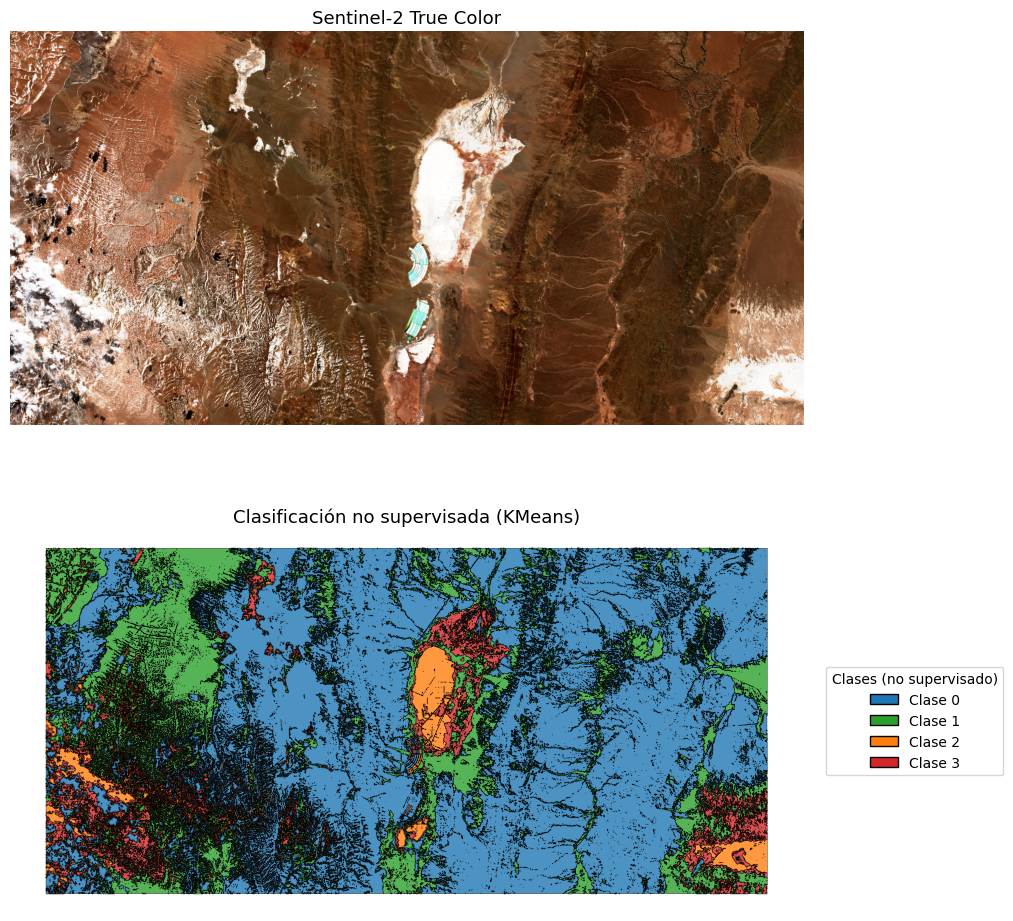

In [3]:
# --- Rutas ---
geojson_path = os.path.join(bandas_dir, "etiquetado_no_supervisado.geojson")
true_color_path = os.path.join(
    ruta_imagenes,
    "2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_True_color.tiff"
)

# --- 1) TRUE COLOR ---
with rasterio.open(true_color_path) as src_rgb:
    true_color = src_rgb.read([1, 2, 3]).astype(np.float32)
    crs_rgb = src_rgb.crs

# Visualización: percentiles para que no salga negro/saturado (no toca datos)
vmin, vmax = np.percentile(true_color, (1, 99))
img_rgb = np.clip((true_color - vmin) / (vmax - vmin), 0, 1)
img_rgb = np.transpose(img_rgb, (1, 2, 0))

# --- 3) GEOJSON KMEANS ---
gdf = gpd.read_file(geojson_path)
if gdf.crs is not None and crs_rgb is not None and gdf.crs != crs_rgb:
    gdf = gdf.to_crs(crs_rgb)

clases = sorted(gdf["label"].unique())
colores = ["#1f77b4", "#2ca02c", "#ff7f0e", "#d62728"]
color_map = {clase: colores[i % len(colores)] for i, clase in enumerate(clases)}
gdf["color"] = gdf["label"].map(color_map)

# -------- FIGURA: UNA DEBAJO DE OTRA --------
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# (1) True Color
axes[0].imshow(img_rgb)
axes[0].set_title("Sentinel-2 True Color", fontsize=13)
axes[0].axis("off")

# (3) KMeans (solo polígonos)
gdf.plot(ax=axes[1], color=gdf["color"], edgecolor='black', linewidth=0.3, alpha=0.8)
axes[1].set_title("Clasificación no supervisada (KMeans)", fontsize=13)
axes[1].axis("off")

# Leyenda fuera del tercer panel
legend_elements = [
    Patch(facecolor=color_map[lbl], edgecolor='black', label=f"Clase {lbl}")
    for lbl in clases
]
axes[1].legend(
    handles=legend_elements,
    title="Clases (no supervisado)",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=True
)

plt.tight_layout()
plt.show()


# Aplicación de Técnicas de ML

In [4]:
import numpy as np
import pandas as pd
import rasterio
from rasterio.features import rasterize
from rasterio.windows import Window
import geopandas as gpd
from shapely.geometry import Polygon, MultiPolygon
from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
import joblib
import warnings
warnings.filterwarnings("ignore")

In [11]:
# Bandas Sentinel-2 co-registradas (mismo tamaño / transform / CRS)
B02 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B02_(Raw).tiff"  # Blue
B03 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B03_(Raw).tiff"  # Green
B04 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B04_(Raw).tiff"  # Red
B08 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B08_(Raw).tiff"  # NIR
B11 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B11_(Raw).tiff"  # SWIR

In [12]:
MUESTRAS_GEOJSON = "./imagenes/bandas/iavf_clases.geojson"   # GeoJSON con polígonos etiquetados
CAMPO_CLASE = "class_name"              # "class_name" o "id"
# mapea nombres a enteros (ajustá a tus etiquetas)
CLASS_MAP = {
    "agua_humedad":1, 
    "salina": 2, 
    "suelo_desnudo": 3, 
    "vegetacion": 4
}

In [13]:
MODELO_OUT       = bandas_dir + "models/" + "best_model.pkl"
CLASIFICACION_TIF= bandas_dir + "models/" + "clasificacion_ml.tif"

In [14]:
# ---------- LECTURA RASTER / METADATOS ----------
with rasterio.open(B02) as src0:
    profile = src0.profile.copy()
    transform = src0.transform
    crs = src0.crs
    H, W = src0.height, src0.width

In [15]:
def read_band(path):
    with rasterio.open(path) as s:
        arr = s.read(1).astype("float32")
    # Sentinel-2 L2A suele venir 0..10000 -> escalar a 0..1
    if np.nanmax(arr) > 2.0:
        arr = arr / 10000.0
    return arr

In [16]:
b02 = read_band(B02)
b03 = read_band(B03)
b04 = read_band(B04)
b08 = read_band(B08)
b11 = read_band(B11)

In [17]:
# Indices espectrales
np.seterr(divide='ignore', invalid='ignore')

ndvi = (b08 - b04) / (b08 + b04)
# NDWI clásico (Green vs NIR) o MNDWI (Green vs SWIR) para agua
ndwi = (b03 - b08) / (b03 + b08)
mndwi= (b03 - b11) / (b03 + b11)
# BSI ayuda para salina/suelo desnudo
bsi  = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

In [18]:
# Stack de features
STACK = np.stack([b02, b03, b04, b08, b11, ndvi, ndwi, mndwi, bsi], axis=-1)

In [19]:
# Rasterizar muestras
gdf = gpd.read_file(MUESTRAS_GEOJSON)

In [20]:
# Alinear CRS
if gdf.crs is None or gdf.crs.to_string() != crs.to_string():
    gdf = gdf.to_crs(crs)

In [21]:
# Normaliza polígonos y erosiona 1 píxel para evitar mezcla borde
px = max(abs(transform.a), abs(transform.e))

def erode(geom, d=-px):
    try:
        g = geom.buffer(d)
        return geom if g.is_empty else g
    except Exception:
        return geom

In [22]:
gdf["geom_eroded"] = gdf.geometry.apply(erode)

In [23]:
# Mapeo de clases
if CAMPO_CLASE == "class_name":
    classes_norm = (gdf[CAMPO_CLASE]
                    .astype(str).str.lower()
                    .str.normalize("NFKD").str.encode("ascii","ignore").str.decode("ascii"))
    labels = classes_norm.map(CLASS_MAP).fillna(0).astype(int)
else:
    labels = gdf[CAMPO_CLASE].astype(int)

In [24]:
shapes = [(geom, lab) for geom, lab in zip(gdf["geom_eroded"], labels) if geom is not None and lab>0]

In [25]:
label_raster = rasterize(
    shapes=shapes,
    out_shape=(H, W),
    transform=transform,
    fill=0,
    dtype="uint16"
)

In [26]:
# Dataset
mask = label_raster > 0
X = STACK[mask]            # (N, F)
y = label_raster[mask].astype(int)

In [28]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = "f1_macro"

In [29]:
searches = []

In [30]:
# 1) ExtraTrees
et_pipe = Pipeline([("clf", ExtraTreesClassifier(random_state=42, n_jobs=-1))])
et_grid = {
    "clf__n_estimators": [300, 600, 1000],
    "clf__max_depth": [None, 12, 24, 48],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__max_features": ["sqrt", 0.5, 1.0]
}
searches.append(("ExtraTrees", et_pipe, et_grid))

In [31]:
# 2) RandomForest
rf_pipe = Pipeline([("clf", RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"))])
rf_grid = {
    "clf__n_estimators": [300, 600, 1000],
    "clf__max_depth": [None, 12, 24, 48],
    "clf__min_samples_leaf": [1, 2, 5],
    "clf__max_features": ["sqrt", 0.5, 1.0]
}
searches.append(("RandomForest", rf_pipe, rf_grid))

In [32]:
# 3) HistGradientBoosting
hgb_pipe = Pipeline([("clf", HistGradientBoostingClassifier(random_state=42))])
hgb_grid = {
    "clf__learning_rate": [0.05, 0.1, 0.2],
    "clf__max_depth": [None, 6, 12],
    "clf__max_leaf_nodes": [31, 63, 127],
    "clf__min_samples_leaf": [20, 50, 100],
    "clf__l2_regularization": [0.0, 0.1, 1.0]
}
searches.append(("HistGB", hgb_pipe, hgb_grid))

In [34]:
best_name, best_score, best_est = None, -np.inf, None
results = []

In [38]:
searches.pop()

('SVM_RBF',
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(class_weight='balanced'))]),
 {'svc__C': [0.5, 1, 2, 4], 'svc__gamma': ['scale', 0.1, 0.01, 0.001]})

In [39]:
searches

[('ExtraTrees',
  Pipeline(steps=[('clf', ExtraTreesClassifier(n_jobs=-1, random_state=42))]),
  {'clf__n_estimators': [300, 600, 1000],
   'clf__max_depth': [None, 12, 24, 48],
   'clf__min_samples_leaf': [1, 2, 5],
   'clf__max_features': ['sqrt', 0.5, 1.0]}),
 ('RandomForest',
  Pipeline(steps=[('clf',
                   RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                          random_state=42))]),
  {'clf__n_estimators': [300, 600, 1000],
   'clf__max_depth': [None, 12, 24, 48],
   'clf__min_samples_leaf': [1, 2, 5],
   'clf__max_features': ['sqrt', 0.5, 1.0]}),
 ('HistGB',
  Pipeline(steps=[('clf', HistGradientBoostingClassifier(random_state=42))]),
  {'clf__learning_rate': [0.05, 0.1, 0.2],
   'clf__max_depth': [None, 6, 12],
   'clf__max_leaf_nodes': [31, 63, 127],
   'clf__min_samples_leaf': [20, 50, 100],
   'clf__l2_regularization': [0.0, 0.1, 1.0]})]

In [40]:
for name, model, grid in searches:
    rs = RandomizedSearchCV(
        model, param_distributions=grid, n_iter=15,
        scoring=scorer, cv=cv, n_jobs=-1, random_state=42, verbose=1
    )
    rs.fit(X, y)
    mean_score = rs.best_score_
    results.append((name, mean_score, rs.best_params_))
    print(f"\n>>> {name}: mejor {scorer} = {mean_score:.4f}")
    print("   Mejores hiperparámetros:", rs.best_params_)

    if mean_score > best_score:
        best_name, best_score, best_est = name, mean_score, rs.best_estimator_

Fitting 5 folds for each of 15 candidates, totalling 75 fits

>>> ExtraTrees: mejor f1_macro = 0.9849
   Mejores hiperparámetros: {'clf__n_estimators': 300, 'clf__min_samples_leaf': 1, 'clf__max_features': 1.0, 'clf__max_depth': None}
Fitting 5 folds for each of 15 candidates, totalling 75 fits

>>> RandomForest: mejor f1_macro = 0.9833
   Mejores hiperparámetros: {'clf__n_estimators': 600, 'clf__min_samples_leaf': 2, 'clf__max_features': 0.5, 'clf__max_depth': 24}
Fitting 5 folds for each of 15 candidates, totalling 75 fits

>>> HistGB: mejor f1_macro = 0.9854
   Mejores hiperparámetros: {'clf__min_samples_leaf': 100, 'clf__max_leaf_nodes': 63, 'clf__max_depth': None, 'clf__learning_rate': 0.1, 'clf__l2_regularization': 0.1}


In [42]:
# Mostrar resumen ordenado
print("\n Resultados comparativos:")
for n, s, p in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"  {n:<15} | F1-macro: {s:.4f}")

print(f"\n Mejor modelo: {best_name} con F1-macro={best_score:.4f}")


 Resultados comparativos:
  HistGB          | F1-macro: 0.9854
  HistGB          | F1-macro: 0.9854
  HistGB          | F1-macro: 0.9854
  ExtraTrees      | F1-macro: 0.9849
  ExtraTrees      | F1-macro: 0.9849
  ExtraTrees      | F1-macro: 0.9849
  RandomForest    | F1-macro: 0.9833
  RandomForest    | F1-macro: 0.9833
  RandomForest    | F1-macro: 0.9833

 Mejor modelo: HistGB con F1-macro=0.9854


In [44]:
# Validación final hold-out
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

best_est.fit(Xtr, ytr)

yhat = best_est.predict(Xte)

print("\nReporte hold-out:")
print(classification_report(yte, yhat, digits=3))
print("Matriz de confusión:\n", confusion_matrix(yte, yhat))

joblib.dump(best_est, f"./imagenes/bandas/models/best_model_{best_name}.pkl")
print(f"Modelo guardado como best_model_{best_name}.pkl")


Reporte hold-out:
              precision    recall  f1-score   support

           1      0.972     0.953     0.963      1592
           2      0.991     0.995     0.993      7908
           3      0.997     0.999     0.998      2285
           4      0.992     0.996     0.994       235

    accuracy                          0.990     12020
   macro avg      0.988     0.986     0.987     12020
weighted avg      0.990     0.990     0.990     12020

Matriz de confusión:
 [[1517   68    6    1]
 [  40 7866    1    1]
 [   2    0 2283    0]
 [   1    0    0  234]]
Modelo guardado como best_model_HistGB.pkl


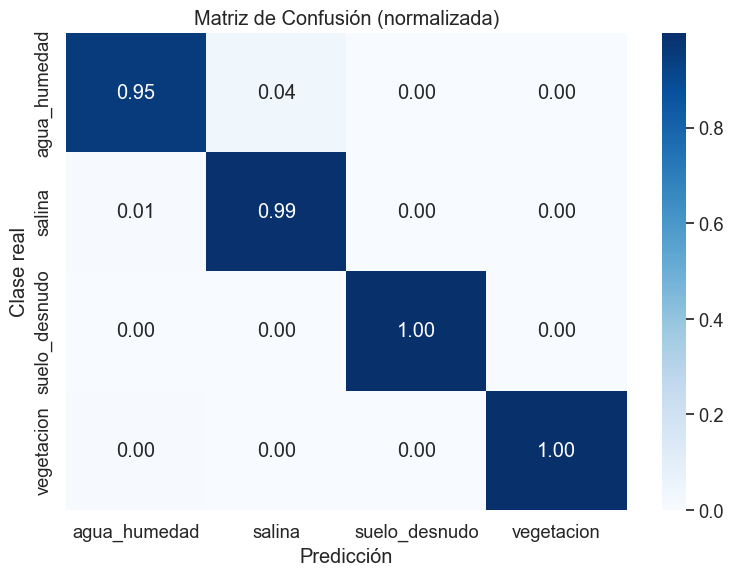

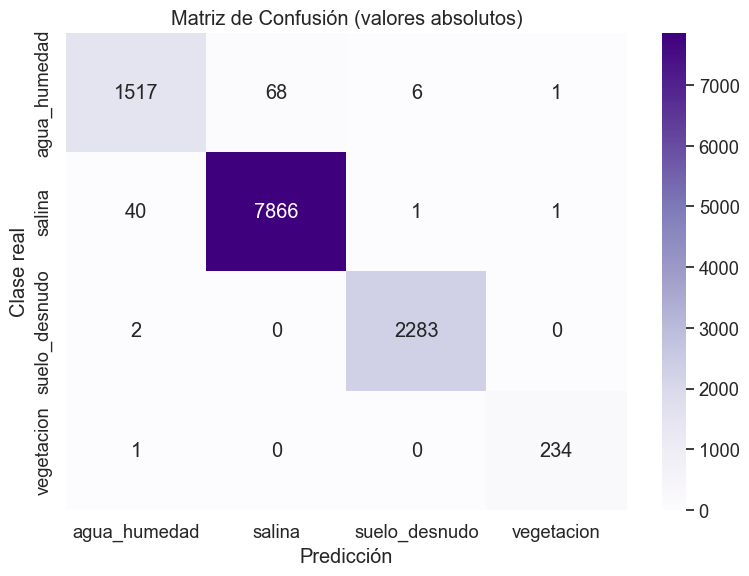

Matrices de confusión exportadas en carpeta 'resultados_ml/'


In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize
from itertools import cycle
import numpy as np
import os


os.makedirs(os.path.join(bandas_dir, "models", "resultados_ml"), exist_ok=True)

# Generamos la matriz
cm = confusion_matrix(yte, yhat)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # normalizada por filas

# Etiquetas de tus clases
class_names = ["agua_humedad", "salina", "suelo_desnudo", "vegetacion"]

# ---- Normalizada ----
plt.figure(figsize=(8,6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión (normalizada)")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.tight_layout()
plt.savefig("./imagenes/bandas/models/resultados_ml/matriz_confusion_normalizada.png", dpi=300)
plt.show()

# ---- Absoluta ----
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión (valores absolutos)")
plt.xlabel("Predicción")
plt.ylabel("Clase real")
plt.tight_layout()
plt.savefig("./imagenes/bandas/models/resultados_ml/matriz_confusion_absoluta.png", dpi=300)
plt.show()

print("Matrices de confusión exportadas en carpeta 'resultados_ml/'")

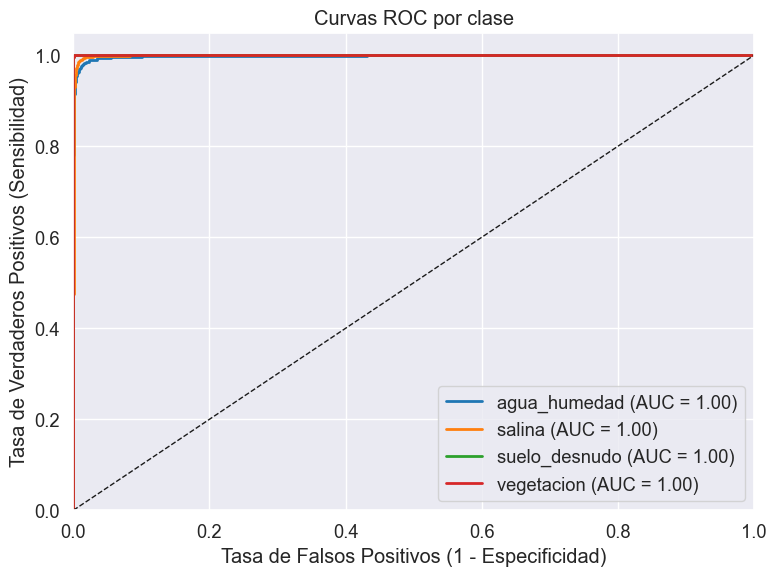

AUC macro promedio: 0.999
Curva ROC exportada en carpeta 'resultados_ml/'


In [49]:
# CURVAS ROC MULTICLASE
# Convertimos etiquetas reales y predicciones a binario (One-vs-Rest)
y_true_bin = label_binarize(yte, classes=[1,2,3,4])
y_score = best_est.predict_proba(Xte)  # probas por clase

# Curva y AUC por clase
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.figure(figsize=(8,6))
colors = cycle(["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"])
for i, color in zip(range(len(class_names)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0,1],[0,1],"k--",lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa de Falsos Positivos (1 - Especificidad)")
plt.ylabel("Tasa de Verdaderos Positivos (Sensibilidad)")
plt.title("Curvas ROC por clase")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("./imagenes/bandas/models/resultados_ml/curva_ROC_multiclase.png", dpi=300)
plt.show()

roc_macro = roc_auc_score(y_true_bin, y_score, average="macro")
print(f"AUC macro promedio: {roc_macro:.3f}")
print("Curva ROC exportada en carpeta 'resultados_ml/'")

In [52]:
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.features import geometry_mask
import geopandas as gpd

# ---------- ENTRADAS ----------
# Bandas Sentinel-2 co-registradas (mismo tamaño / transform / CRS)
B02 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B02_(Raw).tiff"  # Blue
B03 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B03_(Raw).tiff"  # Green
B04 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B04_(Raw).tiff"  # Red
B08 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B08_(Raw).tiff"  # NIR
B11 = bandas_dir + "/2025-06-18-00_00_2025-06-18-23_59_Sentinel-2_L2A_B11_(Raw).tiff"  # SWIR
AOI_PATH = None  # o None si querés todo el raster
CLASIFICACION_TIF = bandas_dir + "/models" + "/clasificacion_ml.tif"
PROB_TIF = bandas_dir + "/models" + "/clasificacion_ml_confianza.tif"

# El modelo ya entrenado/cargado:
# best_est = joblib.load("best_model.pkl")  # si lo cargás desde disco

# Bloques
BLOCK = 2048  # RAM

# ---------- HELPERS ----------
def read_band_win(path, win):
    with rasterio.open(path) as s:
        arr = s.read(1, window=win).astype("float32")
        # escalar si viene 0..10000 (Sentinel-2 L2A)
        if np.nanmax(arr) > 2.0:
            arr = arr / 10000.0
        return arr

# ---------- METADATOS BASE ----------
with rasterio.open(B02) as src0:
    H, W = src0.height, src0.width
    profile = src0.profile.copy()
    transform = src0.transform
    crs = src0.crs
    nodata = src0.nodata  # puede ser None

# ---------- AOI MASK (opcional) ----------
aoi_mask_full = None
if AOI_PATH is not None:
    aoi = gpd.read_file(AOI_PATH)
    if aoi.crs is None or aoi.crs.to_string() != crs.to_string():
        aoi = aoi.to_crs(crs)
    # máscara booleana True=fuera del AOI, False=dentro (invert=False da True fuera)
    aoi_mask_full = geometry_mask(
        geometries=aoi.geometry,
        out_shape=(H, W),
        transform=transform,
        invert=True  # True = dentro del AOI
    )

# ---------- SALIDAS ----------
pred_map = np.zeros((H, W), dtype="uint16")

# si querés también “confianza” (prob máx) y tu modelo soporta predict_proba:
want_confidence = hasattr(best_est, "predict_proba")
conf_map = np.zeros((H, W), dtype="float32") if want_confidence else None

# ---------- LOOP POR BLOQUES ----------
for r0 in range(0, H, BLOCK):
    for c0 in range(0, W, BLOCK):
        h = min(BLOCK, H - r0)
        w = min(BLOCK, W - c0)
        win = Window(c0, r0, w, h)
        sl = np.s_[r0:r0+h, c0:c0+w]

        # Leer bandas en la ventana
        b02 = read_band_win(B02, win)
        b03 = read_band_win(B03, win)
        b04 = read_band_win(B04, win)
        b08 = read_band_win(B08, win)
        b11 = read_band_win(B11, win)

        # Índices (evitar warnings de división)
        np.seterr(divide='ignore', invalid='ignore')
        ndvi  = (b08 - b04) / (b08 + b04)
        ndwi  = (b03 - b08) / (b03 + b08)
        mndwi = (b03 - b11) / (b03 + b11)
        bsi   = ((b11 + b04) - (b08 + b02)) / ((b11 + b04) + (b08 + b02))

        # Stack de features
        stack_w = np.stack([b02, b03, b04, b08, b11, ndvi, ndwi, mndwi, bsi], axis=-1)

        # Máscara de válidos (no NaN y opcional: nodata≠valor)
        valid = np.isfinite(stack_w).all(axis=-1)
        if nodata is not None:
            # si definís nodata en bandas, podés sumar condición: (b02!=nodata)&(b03!=nodata)...
            pass

        # Si hay AOI, combinamos: clasificar solo donde valid & dentro AOI
        if aoi_mask_full is not None:
            valid = valid & aoi_mask_full[sl]

        if not np.any(valid):
            continue  # nada que clasificar en esta ventana

        # Aplanar solo válidos
        flat = stack_w[valid].reshape(-1, stack_w.shape[-1])

        # Predecir
        y_pred = best_est.predict(flat).astype("uint16")

        # Escribir de vuelta en su posición
        block_pred = np.zeros((h, w), dtype="uint16")
        block_pred[valid] = y_pred
        pred_map[sl] = block_pred

        # Confianza (prob máx)
        if want_confidence:
            proba = best_est.predict_proba(flat)      # (N, n_clases)
            conf  = np.max(proba, axis=1).astype("float32")
            block_conf = np.zeros((h, w), dtype="float32")
            block_conf[valid] = conf
            conf_map[sl] = block_conf

# ---------- GUARDAR GeoTIFF CLASIFICADO ----------
out_prof = profile.copy()
out_prof.update({"count": 1, "dtype": "uint16", "compress": "deflate"})
with rasterio.open(CLASIFICACION_TIF, "w", **out_prof) as dst:
    dst.write(pred_map, 1)
    # Paleta
    try:
        PALETTE = {
            0:(0,0,0),
            1:(70,130,180),   # agua_humedad
            2:(245,245,245),  # salina
            3:(181,101,29),    # suelo_desnudo
            4:(0,160,0),      # vegetacion            
        }
        dst.write_colormap(1, PALETTE)
    except Exception:
        pass

print("Clasificación guardada:", CLASIFICACION_TIF)

# ---------- GUARDAR MAPA DE CONFIANZA (opcional) ----------
if want_confidence and conf_map is not None:
    conf_prof = profile.copy()
    conf_prof.update({"count": 1, "dtype": "float32", "compress": "deflate"})
    with rasterio.open(PROB_TIF, "w", **conf_prof) as dst:
        dst.write(conf_map, 1)
    print("Mapa de confianza guardado:", PROB_TIF)

Clasificación guardada: C:\Users\pablonicolasr\Desktop\pablonicolas\educacion_formal\doctorado_ingenieria_uns\ia2025\repo\ia2025\imagenes\bandas/models/clasificacion_ml.tif
Mapa de confianza guardado: C:\Users\pablonicolasr\Desktop\pablonicolas\educacion_formal\doctorado_ingenieria_uns\ia2025\repo\ia2025\imagenes\bandas/models/clasificacion_ml_confianza.tif


Dimensiones: (1240, 2500), dtype: uint16
No se encontró leyenda, usando colores por defecto.
Clases únicas detectadas: [0 1 2 3 4]
🖼️ Imagen exportada correctamente: C:\Users\pablonicolasr\Desktop\pablonicolas\educacion_formal\doctorado_ingenieria_uns\ia2025\repo\ia2025\imagenes\bandas\clasificacion_ml_vista.png


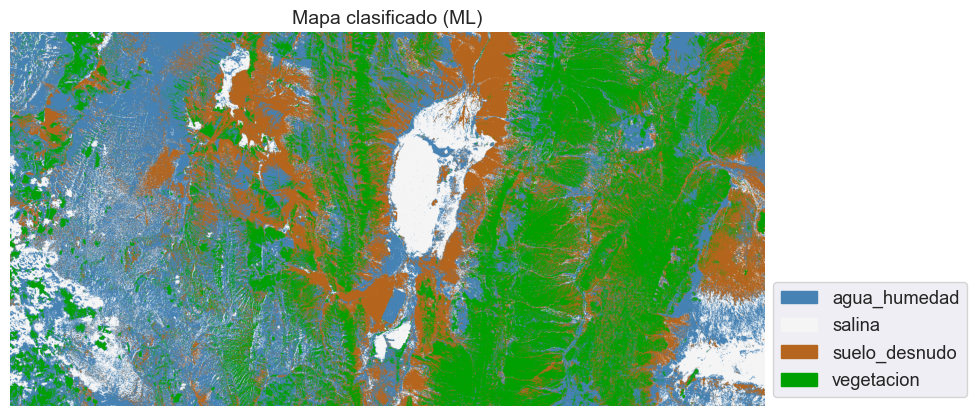

In [53]:
import rasterio
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import json
from matplotlib.colors import ListedColormap, BoundaryNorm


LEYENDA_JSON = "./imagenes/bandas/leyenda_clasificado.json"  # opcional
OUTPUT_IMG = bandas_dir + "/clasificacion_ml_vista.png"  # salida en PNG

# Leer raster
with rasterio.open(CLASIFICACION_TIF) as src:
    clasificado = src.read(1)
    print(f"Dimensiones: {clasificado.shape}, dtype: {clasificado.dtype}")

# ---------- LEYENDA ----------
try:
    with open(LEYENDA_JSON, "r") as f:
        leyenda = json.load(f)
    leyenda = {int(k): v for k, v in leyenda.items()}
    print("Leyenda cargada desde JSON")
except FileNotFoundError:
    # Si no existe el JSON, definimos una por defecto
    leyenda = {
        1: "agua_humedad",
        2: "salina",
        3: "suelo_desnudo",
        4: "vegetacion",        
    }
    print("No se encontró leyenda, usando colores por defecto.")

# ---------- CLASES Y COLORES ----------
clases_unicas = np.unique(clasificado)
print(f"Clases únicas detectadas: {clases_unicas}")

PALETTE = {
    0: (0, 0, 0),             # nodata
    1: (70, 130, 180),        # agua_humedad
    2: (245, 245, 245),       # salina
    3: (181, 101, 29),         # suelo_desnudo
    4: (0, 160, 0),           # vegetacion
    
}

# Crear colormap personalizado
colors = [np.array(PALETTE[c]) / 255 for c in clases_unicas if c in PALETTE]
cmap = ListedColormap(colors)
norm = BoundaryNorm(clases_unicas.tolist() + [clases_unicas[-1] + 1], len(clases_unicas))

# ---------- PLOTEO ----------
plt.figure(figsize=(10, 10))
img = plt.imshow(clasificado, cmap=cmap, norm=norm)
plt.title("Mapa clasificado (ML)", fontsize=14)
plt.axis("off")

# ---------- LEYENDA ----------
patches = []
for i, clase in enumerate(clases_unicas):
    if clase in leyenda:
        color = colors[i] if i < len(colors) else (0, 0, 0)
        patches.append(mpatches.Patch(color=color, label=leyenda[clase]))

plt.legend(handles=patches, loc="lower left", bbox_to_anchor=(1, 0))
plt.tight_layout()

# ---------- EXPORTAR IMAGEN ----------
plt.savefig(OUTPUT_IMG, dpi=300, bbox_inches="tight", facecolor="white")
print(f"🖼️ Imagen exportada correctamente: {os.path.abspath(OUTPUT_IMG)}")

plt.show()

In [54]:
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd

prec, rec, f1, sup = precision_recall_fscore_support(yte, yhat)
df_metrics = pd.DataFrame({
    "Clase": class_names,
    "Precision": prec,
    "Recall": rec,
    "F1-score": f1,
    "Muestras": sup
})
df_metrics.to_csv("./imagenes/bandas/models/resultados_ml/metricas_por_clase.csv", index=False)
print("Métricas exportadas a resultados_ml/metricas_por_clase.csv")

Métricas exportadas a resultados_ml/metricas_por_clase.csv


# Código para calcular el área por clase (en hectáreas)

In [55]:
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import json
from collections import Counter
import os


ruta_leyenda = "./imagenes/bandas/resultados_ml/leyenda_clasificado.json"
salida_csv = "./imagenes/bandas/models/resultados_ml/areas_por_clase.csv"
salida_grafico = "./imagenes/bandas/models/resultados_ml/areas_por_clase.png"

# Se lee raster
with rasterio.open(CLASIFICACION_TIF) as src:
    clasificado = src.read(1)
    perfil = src.profile
    transform = src.transform

# Leyenda
try:
    with open(ruta_leyenda, "r") as f:
        leyenda = json.load(f)
    leyenda = {int(k): v for k, v in leyenda.items()}
    print("Leyenda cargada desde JSON")
except FileNotFoundError:
    leyenda = {
        1: "agua_humedad",
        2: "salina",
        3: "suelo_desnudo",
        4: "vegetacion",
        
    }
    print("No se encontró leyenda, usando por defecto.")

# Se calcula areas
conteo_pixeles = Counter(clasificado.flatten())
conteo_pixeles = {k: v for k, v in conteo_pixeles.items() if k in leyenda}

# área de un píxel (en hectáreas)
pixel_area_ha = (perfil["transform"][0] * -perfil["transform"][4]) / 10000

df_area = pd.DataFrame([
    {
        "clase_id": clase,
        "nombre_clase": leyenda[clase],
        "pixeles": n_pix,
        "hectareas": n_pix * pixel_area_ha
    }
    for clase, n_pix in sorted(conteo_pixeles.items())
])


No se encontró leyenda, usando por defecto.


In [56]:
# Resultados
print("\n Tabla de área por clase:")
print(df_area)

# Exportar CSV
df_area.to_csv(salida_csv, index=False)
print(f" Tabla exportada: {os.path.abspath(salida_csv)}")


 Tabla de área por clase:
   clase_id   nombre_clase  pixeles      hectareas
0         1   agua_humedad  1090086  304092.335119
1         2         salina   361360  100805.630215
2         3  suelo_desnudo   728312  203171.214725
3         4     vegetacion   920147  256685.848531
 Tabla exportada: C:\Users\pablonicolasr\Desktop\pablonicolas\educacion_formal\doctorado_ingenieria_uns\ia2025\repo\ia2025\imagenes\bandas\models\resultados_ml\areas_por_clase.csv


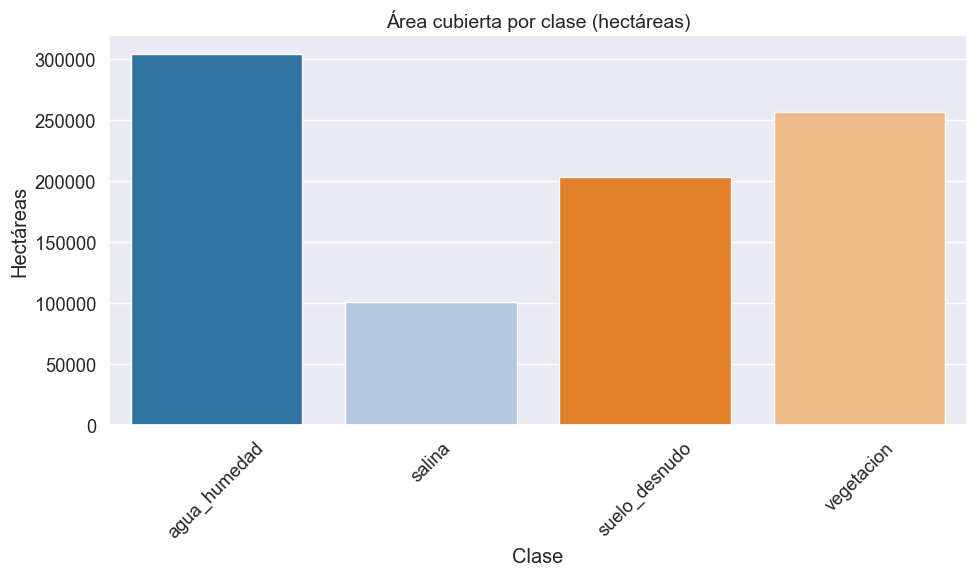

Gráfico exportado: C:\Users\pablonicolasr\Desktop\pablonicolas\educacion_formal\doctorado_ingenieria_uns\ia2025\repo\ia2025\imagenes\bandas\models\resultados_ml\areas_por_clase.png


In [57]:
# Grafico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_area, x="nombre_clase", y="hectareas", palette="tab20")
plt.title("Área cubierta por clase (hectáreas)", fontsize=14)
plt.ylabel("Hectáreas")
plt.xlabel("Clase")
plt.xticks(rotation=45)
plt.tight_layout()

# Exportar gráfico
plt.savefig(salida_grafico, dpi=300, bbox_inches="tight", facecolor="white")
plt.show()

print(f"Gráfico exportado: {os.path.abspath(salida_grafico)}")